## MOUNT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/MSc_project/.MAIN

Mounted at /content/drive
/content/drive/My Drive/MSc_project/.MAIN


## PIPS

In [2]:
!pip install pandas==1.2.4
!pip install xgboost
!pip install lightgbm
!pip install tweet-preprocessor
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 22.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 30.5 MB/s 
     |████████████████████████████████| 6.6 MB 49.8 MB/s 
     |████████████████████████████████| 120 kB 68.3 MB/s 


## DATA LOAD AND CLEAN

In [3]:
import pandas as pd
import os.path

import nltk
from nltk.stem import PorterStemmer # for stemming
from nltk.stem import WordNetLemmatizer # for lemmatization
from nltk.corpus import stopwords
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, Booster
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

import preprocessor as p
import joblib

In [4]:
df=pd.read_csv('user_gender_class/data/gender-classifier-DFE-791531.csv',encoding='latin1')

df.drop(['_unit_id','_last_judgment_at','created','fav_number','profileimage','retweet_count','tweet_coord',
         '_trusted_judgments', 'tweet_count', 'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone', 
         '_golden','_unit_state', 'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'sidebar_color', 
         'profile_yn', 'profile_yn:confidence','gender:confidence'], axis=1, inplace=True)

df.isna().sum()
df.dropna(axis=0,inplace=True)
df['gender'].value_counts()
df['gender'] = df[(df['gender'] == 'female') | (df['gender'] == 'male')]
df['gender'].value_counts()

female    5725
male      5469
Name: gender, dtype: int64

In [5]:
for gen in df['gender']:
  #print(gen)
  if gen=='male':
    df['gender'].replace({'male':'1'},inplace=True)
  elif gen=='female':
    df['gender'].replace({'female':'0'},inplace=True)



df = df[df['gender'].notna()]
print(df['gender'].value_counts())

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

nltk.download('omw-1.4')
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)

lemma = WordNetLemmatizer()
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

def tokenization(text):
    text = re.split('\W+', text)
    return text


print('now cleaning')

p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.NUMBER)
df['clean_description'] = df.description.map(remove_rt).map(rt).map(p.clean).str.lower()#.apply(lambda x: tokenization(x)).apply(lambda x: remove_stopwords(x))
df['clean_text'] = df.text.map(remove_rt).map(rt).map(p.clean).str.lower()#.apply(lambda x: tokenization(x)).apply(lambda x: remove_stopwords(x))

# df['clean_description'] = df.clean_description.apply(lambda lst: [lemma.lemmatize(word) for word in lst]).str.join(" ")
# df['clean_text'] = df.clean_text.apply(lambda lst: [lemma.lemmatize(word) for word in lst]).str.join(" ")

df['texty'] = df.text.map(remove_rt).map(rt).map(p.clean).str.lower()
df['desc'] = df.description.map(remove_rt).map(rt).map(p.clean).str.lower()

n = len(df)
df['sep'] = ['. \n ' for i in range(n)]

df['txt'] = df['desc'] + df['sep'] + df['texty']

df['gender'] = (df['gender']).astype(int)  

0    5725
1    5469
Name: gender, dtype: int64


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


now cleaning


# BERT for DESCRIPTION

### IMPORTS

In [ ]:
import tensorflow as tf
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import pandas as pd
import random, time
from babel.dates import format_date, format_datetime, format_time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score


import torch
from torch import Tensor
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

import transformers, os
from transformers import BertModel, AutoModel, AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification
from transformers import RobertaModel, AutoModel, AdamW, get_linear_schedule_with_warmup, RobertaTokenizer, RobertaForSequenceClassification
from transformers import AutoTokenizer, RobertaConfig

### BERT MODEL

In [ ]:
df['gender'] = (df['gender']).astype(int)


# Split test and train data using 25% of the dataset for validation purposes
x_train, x_test, y_train, y_test = train_test_split(df['clean_description'], 
                                                      df['gender'], test_size=0.2, shuffle=True, random_state=42)

# Obtain a 10% test set from train set
X_train_Transformer, X_val_Transformer, y_train_Transformer, y_val_Transformer = train_test_split(
                                                    x_train, y_train, test_size=0.20, random_state=42)

model_name = 'bert-base-uncased'
SEQ_LEN = 128
batch_size = 16
epochs = 3
learning_rate = 1e-5 # Controls how large a step is taken when updating model weights during training.
steps_per_epoch = int(len(df)/16)
num_workers = 3

def get_split(text1):
    '''Get split of the text with 200 char lenght'''
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return str(l_total)

# Splits train and validation sets to be feed to the transformer which only accepts 512 tokens maximum
split_train_text = [get_split(t) for t in X_train_Transformer]
split_valid_text = [get_split(t) for t in X_val_Transformer]
split_test_text = [get_split(t) for t in x_test]


# Load the RoBERTa tokenizer and tokenize the data
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

trencoding = tokenizer.batch_encode_plus(
  list(split_train_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

valencoding = tokenizer.batch_encode_plus(
  list(split_valid_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)


testencoding = tokenizer.batch_encode_plus(
  list(split_test_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes = np.unique(df['gender'].values.tolist()), 
                                 y = df['gender'])

#print(class_wts)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 
cross_entropy  = nn.CrossEntropyLoss(weight=weights)

def loadData(prep_df, batch_size, num_workers, sampler):
    
    return  DataLoader(
            prep_df,
            batch_size=batch_size,
            num_workers=num_workers,
            sampler=sampler,
            pin_memory=True
        )

## convert lists to tensors
train_seq = torch.tensor(trencoding['input_ids'])
train_mask = torch.tensor(trencoding['attention_mask'])
train_token_ids = torch.tensor(trencoding['token_type_ids'])
train_y = torch.tensor(y_train_Transformer.tolist())

val_seq = torch.tensor(valencoding['input_ids'])
val_mask = torch.tensor(valencoding['attention_mask'])
val_token_ids = torch.tensor(valencoding['token_type_ids'])
val_y = torch.tensor(y_val_Transformer.tolist())

test_seq = torch.tensor(testencoding['input_ids'])
test_mask = torch.tensor(testencoding['attention_mask'])
test_token_ids = torch.tensor(testencoding['token_type_ids'])
test_y = torch.tensor(y_test.tolist())

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_token_ids, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# Train Data Loader
traindata = loadData(train_data, batch_size, num_workers, train_sampler)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_token_ids, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# Val Data Loader
valdata = loadData(val_data, batch_size, num_workers, val_sampler)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_token_ids, test_y)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# Val Data Loader
testdata = loadData(test_data, batch_size, num_workers, test_sampler)


print('Number of data in the train set', len(traindata))
print('Number of data in the validation set', len(valdata))
print('Number of data in the test set', len(testdata))

class BERT_Arch(nn.Module):
    
    def __init__(self, n_classes, freeze_bert=False):
        
        super(BERT_Arch,self).__init__()
        # Instantiating BERT model object
        self.bert = BertModel.from_pretrained(model_name, return_dict=False)
        
        # Freeze bert layers
        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False
                
        self.bert_drop_1 = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size) # (768, 64)
        self.bn = nn.BatchNorm1d(768) # (768)
        self.bert_drop_2 = nn.Dropout(0.25)
        self.out = nn.Linear(self.bert.config.hidden_size, 2) # (768,2)


    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids
        )
        output = self.bert_drop_1(output)
        output = self.fc(output)
        output = self.bn(output)
        output = self.bert_drop_2(output)
        output = self.out(output)        
        return output

class_names = np.unique(df['gender'])
print('Downloading the BERT custom model...')
model = BERT_Arch(len(class_names))
model.to(device) # Model to GPU.

#optimizer parameters
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [{'params': [p for n, p in param_optimizer 
                                    if not any(nd in n for nd in no_decay)],'weight_decay':0.001},
                        {'params': [p for n, p in param_optimizer 
                                    if any(nd in n for nd in no_decay)],'weight_decay':0.0}]

print('Preparing the optimizer...')
#optimizer 
optimizer = AdamW(optimizer_parameters, lr=learning_rate)
steps = steps_per_epoch
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = steps
)


Loading BERT tokenizer...


Number of data in the train set 448
Number of data in the validation set 112
Number of data in the test set 140


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Preparing the optimizer...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


### TRAINING AND EVAL FUNCS

In [ ]:
# function to train the bert model
def trainMODEL():
  
    print('Training...')
    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step, batch in enumerate(traindata):
    
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(traindata)))

        if torch.cuda.is_available():
            # push the batch to gpu
            batch = [r.to(device) for r in batch]

        sent_id, mask, token_type_ids, labels = batch
        # clear previously calculated gradients 
        model.zero_grad()        
        # get model predictions for the current batch
        preds = model(sent_id, mask, token_type_ids)
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
        # append the model predictions
        total_preds.append(preds)
        
        torch.cuda.empty_cache()

    # compute the training loss of the epoch
    avg_loss = total_loss / len(traindata)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

# function for evaluating the model
def evaluate():
  
    print("\nEvaluating...")
    t0 = time.time()
    
    model.eval() # deactivate dropout layers
    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(valdata):
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(valdata)))

        if torch.cuda.is_available():
            # push the batch to gpu
            batch = [t.to(device) for t in batch]

        sent_id, mask, token_type_ids, labels = batch

        # deactivate autograd
        with torch.no_grad(): # Dont store any previous computations, thus freeing GPU space

            # model predictions
            preds = model(sent_id, mask, token_type_ids)
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

        torch.cuda.empty_cache()
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(valdata) 
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

## TRAINING

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# Empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

# for each epoch perform training and evaluation
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = trainMODEL()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    print('Evaluation done for epoch {}'.format(epoch + 1))
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print('Saving model...')
        torch.save(model.state_dict(), 'user_gender_class/desc_gender.pt') # Save model weight's (you can also save it in .bin format)
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 3
Training...
  Batch    50  of    448.
  Batch   100  of    448.
  Batch   150  of    448.
  Batch   200  of    448.
  Batch   250  of    448.
  Batch   300  of    448.
  Batch   350  of    448.
  Batch   400  of    448.

Evaluating...
  Batch    50  of    112.
  Batch   100  of    112.
Evaluation done for epoch 1
Saving model...

Training Loss: 0.690
Validation Loss: 0.598

 Epoch 2 / 3
Training...
  Batch    50  of    448.
  Batch   100  of    448.
  Batch   150  of    448.
  Batch   200  of    448.
  Batch   250  of    448.
  Batch   300  of    448.
  Batch   350  of    448.
  Batch   400  of    448.

Evaluating...
  Batch    50  of    112.
  Batch   100  of    112.
Evaluation done for epoch 2
Saving model...

Training Loss: 0.586
Validation Loss: 0.595

 Epoch 3 / 3
Training...
  Batch    50  of    448.
  Batch   100  of    448.
  Batch   150  of    448.
  Batch   200  of    448.
  Batch   250  of    448.
  Batch   300  of    448.
  Batch   350  of    448.
  Batch   40

## TEST set

In [ ]:
print('\nTest Set...')

test_preds = []

print('Total batches:', len(testdata))

for fold_index in range(0, 3):
    
    print('\nFold Model', fold_index)
    
    # Load the fold model
    path_model = 'user_gender_class/desc_gender.pt'
    model.load_state_dict(torch.load(path_model))

    # Send the model to the GPU
    model.to(device)

    stacked_val_labels = []
    
    # Put the model in evaluation mode.
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Reset the total loss for this epoch.
    total_val_loss = 0

    for j, test_batch in enumerate(testdata):

        inference_status = 'Batch ' + str(j + 1)

        print(inference_status, end='\r')

        b_input_ids = test_batch[0].to(device)
        b_input_mask = test_batch[1].to(device)
        b_token_type_ids = test_batch[2].to(device)
        b_test_y = test_batch[3].to(device)


        outputs = model(b_input_ids, 
                        attention_mask=b_input_mask,
                        token_type_ids=b_token_type_ids)

        # Get the preds
        preds = outputs[0]

        # Move preds to the CPU
        val_preds = preds.detach().cpu().numpy()
        
        #true_labels.append(b_test_y.to('cpu').numpy().flatten())
        
        # Stack the predictions.
        if j == 0:  # first batch
            stacked_val_preds = val_preds
            
        else:
            stacked_val_preds = np.vstack((stacked_val_preds, val_preds))
            
    test_preds.append(stacked_val_preds)
    
            
print('\nPrediction complete.')


Test Set...
Total batches: 140

Fold Model 0
Batch 140
Fold Model 1
Batch 140
Fold Model 2
Batch 140
Prediction complete.


[0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0]


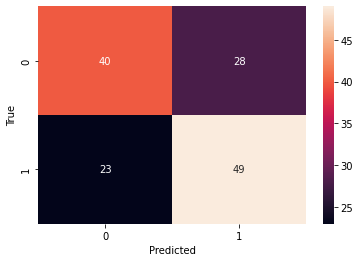

----
Accuracy of BERT model 0.6357142857142857
----
              precision    recall  f1-score   support

      true_y       0.63      0.59      0.61        68
 predicted_y       0.64      0.68      0.66        72

    accuracy                           0.64       140
   macro avg       0.64      0.63      0.63       140
weighted avg       0.64      0.64      0.63       140



In [ ]:
# Sum the predictions of all fold models
for i, item in enumerate(test_preds):
    if i == 0:
        preds = item
    else:
        # Sum the matrices
        preds = item + preds

# Average the predictions
avg_preds = preds/(len(test_preds))

#print(preds)
#print()
#print(avg_preds)

# Take the argmax. 
# This returns the column index of the max value in each row.
test_predictions = np.argmax(avg_preds, axis=1)

true_y = []
for j, test_batch in enumerate(testdata):
    true_y.append(int(test_batch[3][0].numpy().flatten()))
print(true_y)

# Accuracy and classification report 
target_names = ['true_y', 'predicted_y']

data = {'true_y': true_y,
       'predicted_y': test_predictions}

df_pred_BERT = pd.DataFrame(data, columns=['true_y','predicted_y'])

confusion_matrix = pd.crosstab(df_pred_BERT['true_y'], df_pred_BERT['predicted_y'], rownames=['True'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

print('----')
print('Accuracy of BERT model', accuracy_score(true_y, test_predictions))
print('----')

print(classification_report(true_y, test_predictions, target_names=target_names))

# BERT for TWEET AND DESCRIPTION

### IMPORTS

In [ ]:
import tensorflow as tf
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import pandas as pd
import random, time
from babel.dates import format_date, format_datetime, format_time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score


import torch
from torch import Tensor
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

import transformers, os
from transformers import BertModel, AutoModel, AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification
from transformers import RobertaModel, AutoModel, AdamW, get_linear_schedule_with_warmup, RobertaTokenizer, RobertaForSequenceClassification
from transformers import AutoTokenizer, RobertaConfig

### BERT MODEL

In [ ]:
df['gender'] = (df['gender']).astype(int)


# Split test and train data using 25% of the dataset for validation purposes
x_train, x_test, y_train, y_test = train_test_split(df['txt'], 
                                                      df['gender'], test_size=0.2, shuffle=True, random_state=42)

# Obtain a 10% test set from train set
X_train_Transformer, X_val_Transformer, y_train_Transformer, y_val_Transformer = train_test_split(
                                                    x_train, y_train, test_size=0.20, random_state=42)

model_name = 'bert-base-uncased'
SEQ_LEN = 256
batch_size = 16
epochs = 3
learning_rate = 1e-5 # Controls how large a step is taken when updating model weights during training.
steps_per_epoch = int(len(df)/16)
num_workers = 3

def get_split(text1):
    '''Get split of the text with 200 char lenght'''
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return str(l_total)

# Splits train and validation sets to be feed to the transformer which only accepts 512 tokens maximum
split_train_text = [get_split(t) for t in X_train_Transformer]
split_valid_text = [get_split(t) for t in X_val_Transformer]
split_test_text = [get_split(t) for t in x_test]


# Load the RoBERTa tokenizer and tokenize the data
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

trencoding = tokenizer.batch_encode_plus(
  list(split_train_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

valencoding = tokenizer.batch_encode_plus(
  list(split_valid_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)


testencoding = tokenizer.batch_encode_plus(
  list(split_test_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes = np.unique(df['gender'].values.tolist()), 
                                 y = df['gender'])

#print(class_wts)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 
cross_entropy  = nn.CrossEntropyLoss(weight=weights)

def loadData(prep_df, batch_size, num_workers, sampler):
    
    return  DataLoader(
            prep_df,
            batch_size=batch_size,
            num_workers=num_workers,
            sampler=sampler,
            pin_memory=True
        )

## convert lists to tensors
train_seq = torch.tensor(trencoding['input_ids'])
train_mask = torch.tensor(trencoding['attention_mask'])
train_token_ids = torch.tensor(trencoding['token_type_ids'])
train_y = torch.tensor(y_train_Transformer.tolist())

val_seq = torch.tensor(valencoding['input_ids'])
val_mask = torch.tensor(valencoding['attention_mask'])
val_token_ids = torch.tensor(valencoding['token_type_ids'])
val_y = torch.tensor(y_val_Transformer.tolist())

test_seq = torch.tensor(testencoding['input_ids'])
test_mask = torch.tensor(testencoding['attention_mask'])
test_token_ids = torch.tensor(testencoding['token_type_ids'])
test_y = torch.tensor(y_test.tolist())

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_token_ids, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# Train Data Loader
traindata = loadData(train_data, batch_size, num_workers, train_sampler)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_token_ids, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# Val Data Loader
valdata = loadData(val_data, batch_size, num_workers, val_sampler)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_token_ids, test_y)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# Val Data Loader
testdata = loadData(test_data, batch_size, num_workers, test_sampler)


print('Number of data in the train set', len(traindata))
print('Number of data in the validation set', len(valdata))
print('Number of data in the test set', len(testdata))

class BERT_Arch(nn.Module):
    
    def __init__(self, n_classes, freeze_bert=False):
        
        super(BERT_Arch,self).__init__()
        # Instantiating BERT model object
        self.bert = BertModel.from_pretrained(model_name, return_dict=False)
        
        # Freeze bert layers
        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False
                
        self.bert_drop_1 = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size) # (768, 64)
        self.bn = nn.BatchNorm1d(768) # (768)
        self.bert_drop_2 = nn.Dropout(0.25)
        self.out = nn.Linear(self.bert.config.hidden_size, 2) # (768,2)


    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids
        )
        output = self.bert_drop_1(output)
        output = self.fc(output)
        output = self.bn(output)
        output = self.bert_drop_2(output)
        output = self.out(output)        
        return output

class_names = np.unique(df['gender'])
print('Downloading the BERT custom model...')
model = BERT_Arch(len(class_names))
model.to(device) # Model to GPU.

#optimizer parameters
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [{'params': [p for n, p in param_optimizer 
                                    if not any(nd in n for nd in no_decay)],'weight_decay':0.001},
                        {'params': [p for n, p in param_optimizer 
                                    if any(nd in n for nd in no_decay)],'weight_decay':0.0}]

print('Preparing the optimizer...')
#optimizer 
optimizer = AdamW(optimizer_parameters, lr=learning_rate)
steps = steps_per_epoch
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = steps
)


Loading BERT tokenizer...


Number of data in the train set 448
Number of data in the validation set 112
Number of data in the test set 140


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Preparing the optimizer...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


### TRAINING AND EVAL FUNCS

In [ ]:
# function to train the bert model
def trainMODEL():
  
    print('Training...')
    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step, batch in enumerate(traindata):
    
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(traindata)))

        if torch.cuda.is_available():
            # push the batch to gpu
            batch = [r.to(device) for r in batch]

        sent_id, mask, token_type_ids, labels = batch
        # clear previously calculated gradients 
        model.zero_grad()        
        # get model predictions for the current batch
        preds = model(sent_id, mask, token_type_ids)
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
        # append the model predictions
        total_preds.append(preds)
        
        torch.cuda.empty_cache()

    # compute the training loss of the epoch
    avg_loss = total_loss / len(traindata)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

# function for evaluating the model
def evaluate():
  
    print("\nEvaluating...")
    t0 = time.time()
    
    model.eval() # deactivate dropout layers
    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(valdata):
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(valdata)))

        if torch.cuda.is_available():
            # push the batch to gpu
            batch = [t.to(device) for t in batch]

        sent_id, mask, token_type_ids, labels = batch

        # deactivate autograd
        with torch.no_grad(): # Dont store any previous computations, thus freeing GPU space

            # model predictions
            preds = model(sent_id, mask, token_type_ids)
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

        torch.cuda.empty_cache()
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(valdata) 
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

## TRAINING

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# Empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

# for each epoch perform training and evaluation
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = trainMODEL()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    print('Evaluation done for epoch {}'.format(epoch + 1))
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print('Saving model...')
        torch.save(model.state_dict(), 'user_gender_class/gender_text.pt') # Save model weight's (you can also save it in .bin format)
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 3
Training...
  Batch    50  of    448.
  Batch   100  of    448.
  Batch   150  of    448.
  Batch   200  of    448.
  Batch   250  of    448.
  Batch   300  of    448.
  Batch   350  of    448.
  Batch   400  of    448.

Evaluating...
  Batch    50  of    112.
  Batch   100  of    112.
Evaluation done for epoch 1
Saving model...

Training Loss: 0.659
Validation Loss: 0.575

 Epoch 2 / 3
Training...
  Batch    50  of    448.
  Batch   100  of    448.
  Batch   150  of    448.
  Batch   200  of    448.
  Batch   250  of    448.
  Batch   300  of    448.
  Batch   350  of    448.
  Batch   400  of    448.

Evaluating...
  Batch    50  of    112.
  Batch   100  of    112.
Evaluation done for epoch 2
Saving model...

Training Loss: 0.549
Validation Loss: 0.542

 Epoch 3 / 3
Training...
  Batch    50  of    448.
  Batch   100  of    448.
  Batch   150  of    448.
  Batch   200  of    448.
  Batch   250  of    448.
  Batch   300  of    448.
  Batch   350  of    448.
  Batch   40

## TEST set

In [ ]:
print('\nTest Set...')

test_preds = []

print('Total batches:', len(testdata))

for fold_index in range(0, 3):
    
    print('\nFold Model', fold_index)
    
    # Load the fold model
    path_model = 'user_gender_class/gender_text.pt'
    model.load_state_dict(torch.load(path_model))

    # Send the model to the GPU
    model.to(device)

    stacked_val_labels = []
    
    # Put the model in evaluation mode.
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Reset the total loss for this epoch.
    total_val_loss = 0

    for j, test_batch in enumerate(testdata):

        inference_status = 'Batch ' + str(j + 1)

        print(inference_status, end='\r')

        b_input_ids = test_batch[0].to(device)
        b_input_mask = test_batch[1].to(device)
        b_token_type_ids = test_batch[2].to(device)
        b_test_y = test_batch[3].to(device)


        outputs = model(b_input_ids, 
                        attention_mask=b_input_mask,
                        token_type_ids=b_token_type_ids)

        # Get the preds
        preds = outputs[0]

        # Move preds to the CPU
        val_preds = preds.detach().cpu().numpy()
        
        #true_labels.append(b_test_y.to('cpu').numpy().flatten())
        
        # Stack the predictions.
        if j == 0:  # first batch
            stacked_val_preds = val_preds
            
        else:
            stacked_val_preds = np.vstack((stacked_val_preds, val_preds))
            
    test_preds.append(stacked_val_preds)
    
            
print('\nPrediction complete.')


Test Set...
Total batches: 140

Fold Model 0

Fold Model 1
Batch 140
Fold Model 2
Batch 140
Prediction complete.


[0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0]


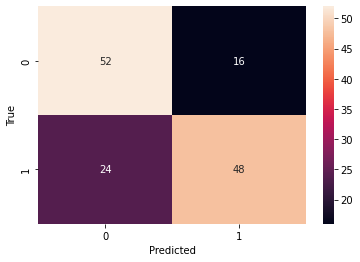

----
Accuracy of BERT model 0.7142857142857143
----
              precision    recall  f1-score   support

      true_y       0.68      0.76      0.72        68
 predicted_y       0.75      0.67      0.71        72

    accuracy                           0.71       140
   macro avg       0.72      0.72      0.71       140
weighted avg       0.72      0.71      0.71       140



In [ ]:
# Sum the predictions of all fold models
for i, item in enumerate(test_preds):
    if i == 0:
        preds = item
    else:
        # Sum the matrices
        preds = item + preds

# Average the predictions
avg_preds = preds/(len(test_preds))

#print(preds)
#print()
#print(avg_preds)

# Take the argmax. 
# This returns the column index of the max value in each row.
test_predictions = np.argmax(avg_preds, axis=1)

true_y = []
for j, test_batch in enumerate(testdata):
    true_y.append(int(test_batch[3][0].numpy().flatten()))
print(true_y)

# Accuracy and classification report 
target_names = ['true_y', 'predicted_y']

data = {'true_y': true_y,
       'predicted_y': test_predictions}

df_pred_BERT = pd.DataFrame(data, columns=['true_y','predicted_y'])

confusion_matrix = pd.crosstab(df_pred_BERT['true_y'], df_pred_BERT['predicted_y'], rownames=['True'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

print('----')
print('Accuracy of BERT model', accuracy_score(true_y, test_predictions))
print('----')

print(classification_report(true_y, test_predictions, target_names=target_names))

# LOGISTIC REGRESSION

In [9]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

nltk.download('omw-1.4')
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)

lemma = WordNetLemmatizer()

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['u', 'wa', 'ha', 'would', 'com'])

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

def tokenization(text):
    text = re.split('\W+', text)
    return text

p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.NUMBER)
df['clean_description'] = df.description.map(remove_rt).map(rt).map(p.clean)#.apply(lambda x: tokenization(x)).apply(lambda x: remove_stopwords(x))
df['clean_text'] = df.text.map(remove_rt).map(rt).map(p.clean)#.apply(lambda x: tokenization(x)).apply(lambda x: remove_stopwords(x))

n = len(df)
df['sep'] = ['.' for i in range(n)]
df['txt'] = df['clean_description'] + df['sep'] + df['clean_text']

df['txt'] = df['txt'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))


df['gender'] = (df['gender']).astype(int)

# Split test and train data using 25% of the dataset for validation purposes
x_train, x_test, y_train, y_test = train_test_split(df['txt'], 
                                                      df['gender'], test_size=0.2, shuffle=True, random_state=42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [25]:
type(x_test)

pandas.core.series.Series

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a Pipeline with the TfidfVectorizer and LogisticRegression model
LR_pipeline = Pipeline(steps = [('tf', TfidfVectorizer()), 
                                ('lgrg', LogisticRegression())]) # initialize TfidfVectorizer and LogisticRegression


# Create Parameter Grid
pgrid_lgrg = {
 'tf__max_features' : [1000, 2000, 3000],
 'tf__ngram_range' : [(1,1),(1,2)],
 'tf__use_idf' : [True, False],
 'lgrg__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
 'lgrg__class_weight' : ['balanced', None]
}

# Apply GridSearch to Pipeline to find the best parameters
gs_lgrg = GridSearchCV(LR_pipeline, pgrid_lgrg, cv=2, n_jobs=-1, verbose=2)

In [12]:
gs_lgrg.fit(x_train, y_train) # Train LR model

Fitting 2 folds for each of 96 candidates, totalling 192 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
96 fits failed out of a total of 192.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  Fi

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('lgrg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lgrg__class_weight': ['balanced', None],
                         'lgrg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'tf__max_features': [1000, 2000, 3000],
                         'tf__ngram_range': [(1, 1), (1, 2)],
                         'tf__use_idf': [True, False]},
             verbose=2)

In [13]:
gs_lgrg.best_params_

{'lgrg__class_weight': None,
 'lgrg__penalty': 'l2',
 'tf__max_features': 3000,
 'tf__ngram_range': (1, 1),
 'tf__use_idf': True}

In [23]:
import joblib 

path = 'user_gender_class/model/logistic_gender'
# joblib.dump(gs_lgrg, path)

mod = joblib.load(path)

print('Score of train set', mod.score(x_train, y_train))
print('Score of test set',mod.score(x_test, y_test))

Score of train set 0.7884980457844779
Score of test set 0.6636891469405984


In [14]:
print('Score of train set', gs_lgrg.score(x_train, y_train))
print('Score of test set',gs_lgrg.score(x_test, y_test))

Score of train set 0.7884980457844779
Score of test set 0.6636891469405984


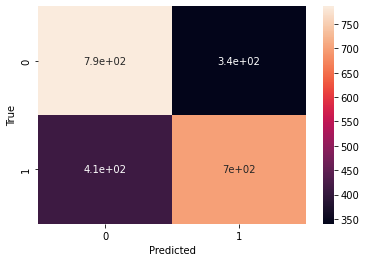

In [15]:
LR_pred = gs_lgrg.predict(x_test) # Predict on validation data

data = {'true_y': y_test,
       'predicted_y': LR_pred}
df_pred = pd.DataFrame(data, columns=['true_y','predicted_y'])
confusion_matrix = pd.crosstab(df_pred['true_y'], df_pred['predicted_y'], rownames=['True'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

In [16]:
print('Accuracy of LR model', accuracy_score(y_test, LR_pred))

Accuracy of LR model 0.6636891469405984


In [18]:
# Accuracy and classification report 
target_names = ['true_y', 'predicted_y']

print(classification_report(y_test, LR_pred, target_names=target_names))

              precision    recall  f1-score   support

      true_y       0.66      0.70      0.68      1126
 predicted_y       0.67      0.63      0.65      1113

    accuracy                           0.66      2239
   macro avg       0.66      0.66      0.66      2239
weighted avg       0.66      0.66      0.66      2239

